# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as ly

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


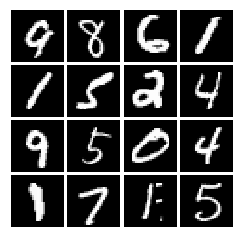

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

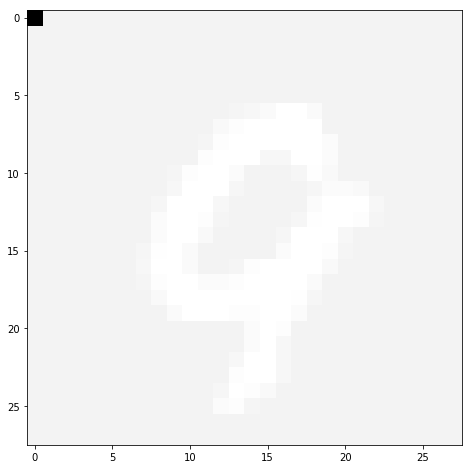

In [16]:
pic = mnist.train.images[0] 
plt.imshow(pic.reshape((28,28)))
pic[0] = -20
plt.imshow(pic.reshape((28,28)))

In [13]:
def sample_noise(batch_size, dim):
    """Generate random normal noise
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_normal(shape=[batch_size, dim],
                            mean=0,
                            stddev=1) 

In [14]:
def leaky_relu(x, alpha=.1):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU    
    
    return tf.maximum(x,0) + tf.minimum(x,0) * alpha

## Discriminator

In [15]:
def discriminator(x):
    '''
    Input : x : [batch_size, 784]
    Output : logits : [batch_size , 1]
    '''
    x = tf.reshape(x, [-1,28,28,1])
    
    with tf.variable_scope('discriminator'):
        
        conv_1 = ly.conv2d(inputs=x, # 28 * 28 * 8 
                           num_outputs=8,
                           kernel_size=1,
                           stride=1,
                           padding='SAME',
                           activation_fn = leaky_relu,
                           normalizer_fn = ly.batch_norm,
                           scope='conv_1')
                           #weights_initializer = tf.random_normal_initializer(0,0.02))
        conv_2 = ly.conv2d(inputs=conv_1, # 14 * 14 * 16 
                           num_outputs=16,
                           kernel_size=3,
                           stride=2,
                           padding='SAME',
                           activation_fn = leaky_relu,
                           normalizer_fn = ly.batch_norm,
                           scope='conv_2')
                           #weights_initializer = tf.random_normal_initializer(0,0.02))
        conv_3 = ly.conv2d(inputs=conv_2, # 7 * 7 * 128
                           num_outputs=32,
                           kernel_size=3,
                           stride=2,
                           padding='SAME',
                           activation_fn = leaky_relu,
                           normalizer_fn = ly.batch_norm,
                           scope='conv_3')
                           #weights_initializer = tf.random_normal_initializer(0,0.02))
        conv_4 = ly.conv2d(inputs=conv_3, # 4 * 4 * 64 
                           num_outputs=64,
                           kernel_size=3,
                           stride=2,
                           padding='SAME',
                           activation_fn = leaky_relu,
                           normalizer_fn = ly.batch_norm,
                           scope='conv_4')
                           #weights_initializer = tf.random_normal_initializer(0,0.02))
        conv_4 = tf.reshape(conv_4, [-1,4*4*64])
        logits = ly.fully_connected(inputs=conv_4, 
                                    num_outputs=1,
                                    weights_initializer = tf.random_uniform_initializer(0,.02),
                                    scope='logits')        
        #print(logits.shape)
        return logits

In [16]:
# tf.reset_default_graph()
# x = tf.random_normal(shape=[10,784])
# with tf.Session() as sess:
#     a = discriminator(x)
#     sess.run(tf.global_variables_initializer())
#     sess.run(a)

## Generator : DConv

In [20]:
def generator(z1,z2,z3):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):

        fc_z1 = ly.fully_connected(inputs=z1, 
                                   num_outputs=3 * 3 * 64,
                                   activation_fn = leaky_relu,
                                   normalizer_fn = ly.batch_norm,
                                   weights_initializer = tf.random_uniform_initializer(0,.02),
                                   scope='fc_z1')
        fc_z1_reshape = tf.reshape(fc_z1, shape=[-1,3,3,64]) # 3 * 3 * 64
        dconv_1 = ly.conv2d_transpose(inputs=fc_z1_reshape, # 7 * 7 * 32
                                      num_outputs=32,
                                      kernel_size=3,
                                      stride=2,
                                      padding='VALID',
                                      activation_fn=leaky_relu,
                                      normalizer_fn=ly.batch_norm,
                                      weights_initializer= tf.random_normal_initializer(0,.02),
                                      scope='dconv_1') 
        
        fc_z2 = ly.fully_connected(inputs=z2, 
                                   num_outputs=7 * 7 * 32,
                                   activation_fn = leaky_relu,
                                   normalizer_fn = ly.batch_norm,
                                   weights_initializer = tf.random_uniform_initializer(0,.02),
                                   scope='fc_z2') 
        fc_z2_reshape = tf.reshape(fc_z2, shape=[-1,7,7,32])
        merge_1 = tf.add(fc_z2_reshape , dconv_1, name='merge_1') # 7 * 7 * 32
        dconv_2 = ly.conv2d_transpose(inputs=merge_1, # 14 * 14 * 16
                                      num_outputs=16,
                                      kernel_size=3,
                                      stride=2,
                                      padding='SAME',
                                      activation_fn=leaky_relu,
                                      normalizer_fn=ly.batch_norm,
                                      weights_initializer= tf.random_normal_initializer(0,.02),
                                      scope='dconv_2')
        
        fc_z3 = ly.fully_connected(inputs=z3, 
                                   num_outputs=14 * 14 * 16,
                                   activation_fn = leaky_relu,
                                   normalizer_fn = ly.batch_norm,
                                   weights_initializer = tf.random_uniform_initializer(0,.02),
                                   scope='fc_z3')
        fc_z3_reshape = tf.reshape(fc_z3, shape=[-1,14,14,16])
        merge_2 = tf.add(fc_z3_reshape , dconv_2, name='merge_2')
        
        dconv_3 = ly.conv2d_transpose(inputs=merge_2, # 28 * 28 * 8
                                      num_outputs=8,
                                      kernel_size=3,
                                      stride=2,
                                      padding='SAME',
                                      activation_fn=leaky_relu,
                                      normalizer_fn=ly.batch_norm,
                                      weights_initializer= tf.random_normal_initializer(0,.02),
                                      scope='dconv_3')
        img = ly.conv2d_transpose(inputs=dconv_3, # 28 * 28 * 1
                                  num_outputs=1,
                                  kernel_size=3,
                                  stride=1,
                                  padding='SAME',
                                  weights_initializer= tf.random_normal_initializer(0,.02),
                                  scope='img')                                 
        img = tf.reshape(img,[-1,784]) # 784
        #print(img.shape)
        return img

In [18]:
tf.reset_default_graph()
with tf.Session() as sess:
    z1 = tf.random_normal([10,16])
    z2 = tf.random_normal([10,20])
    z3 = tf.random_normal([10,8])
    a = generator(z1,z2,z3)
    sess.run(tf.global_variables_initializer())
    sess.run(a)

(10, 784)


## WGANs Loss

In [21]:
def wgangp_loss(logits_real, logits_fake):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss =  - tf.reduce_mean(logits_real - logits_fake)
    
    G_loss =  - tf.reduce_mean(logits_fake)

    return D_loss, G_loss

## Adam Optimizer

In [22]:
def get_solvers(learning_rate=5e-5, beta1=.5, beta2=.9):
    """Create solvers for WGAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,
                                      beta1=beta1, beta2=beta2)
                                         
    
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,
                                      beta1=beta1, beta2=beta2)
    return D_solver, G_solver

## Hyperparameters

In [25]:
# learning rate of two networks
learning_rate_gen = 5e-5
learning_rate_dis = 5e-5

# steps of dis per global step
citers = 5

# batch_size
batch_size = 64

# noise_dim
z1_dim = 3 * 3
z2_dim = 5 * 5
z3_dim = 7 * 7


# leaky relu paramter
alpha = .1

# maxiter = train_samples * epoch / batch_size
epoch = 50
print_every = 100
show_every = 500

# Adam optimizer 
beta1 = .5
beta2 = .9

# restriction on weights of discriminator network
clamp_lower = -.01
clamp_upper = .01

## Build the Graph

In [26]:
tf.reset_default_graph()

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z1 = sample_noise(batch_size=batch_size, dim=z1_dim)
z2 = sample_noise(batch_size=batch_size, dim=z2_dim)
z3 = sample_noise(batch_size=batch_size, dim=z3_dim)
# generated images
G_sample = generator(z1,z2,z3)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs, share parameters
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
D_clip = [v.assign(tf.clip_by_value(v, clamp_lower, clamp_upper)) for v in D_vars]

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = wgangp_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

with tf.control_dependencies([D_train_step]):
    D_train_step = tf.tuple(D_clip)

In [27]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss,\
              show_every=show_every, print_every=print_every,\
              Citers = citers, batch_size=batch_size, num_epoch=epoch):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - Citers : discriminator steps per global step
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        ## every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        ## setting citers per global step    
        if it < 50 or it % 500 == 0:
            citers = 50
        else:
            citers = Citers
            
        for ci in range(citers):
            # update discriminators citers times
            minibatch, _ = mnist.train.next_batch(batch_size)
            if ci != citers - 1:
                sess.run(D_train_step, feed_dict={x:minibatch})
            elif ci == citers - 1: 
                _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x:minibatch})
                    
        # update generator every global step    
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={x: minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

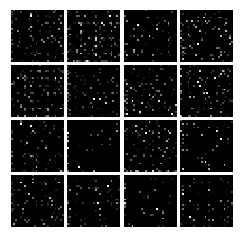


Iter: 0, D: -3.152, G:-0.06737


KeyboardInterrupt: 

In [28]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss)